<h1>IQPEmbedding</h1>

In [1]:
# Importing modules
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers, IQPEmbedding
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt



In [2]:
# Setting parameters

n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/IQPEmbedding" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [3]:
# Loading of the MNIST dataset

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)



In [4]:
"""
We initialize a PennyLane default.qubit device, simulating a system of 4

qubits. The associated qnode represents the quantum circuit consisting of:

1) an embedding layer of local Ry rotations (with angles scaled by a factor of π);
2) a random circuit of n_layers;
3) a final measurement in the computational basis, estimating 4 expectation values.
"""

dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def circuit(features,repeat):
    # Encoding of 4 classical input values
    IQPEmbedding(features, wires =range(4), n_repeats=repeat)

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [5]:
"""
The next function defines the convolution scheme:

1)the image is divided into squares of 2×2 pixels;
2)each square is processed by the quantum circuit;
3)the 4 expectation values are mapped into 4 different channels of a single output pixel.
"""

def quanv(image,repeat):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ], repeat
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out



In [6]:
def Process(repeat):
    if PREPROCESS == True:
        q_train_images = []
        print("Quantum pre-processing of train images:")
        for idx, img in enumerate(train_images):
            print("{}/{}        ".format(idx + 1, n_train), end="\r")
            q_train_images.append(quanv(img,repeat))
        q_train_images = np.asarray(q_train_images)

        q_test_images = []
        print("\nQuantum pre-processing of test images:")
        for idx, img in enumerate(test_images):
            print("{}/{}        ".format(idx + 1, n_test), end="\r")
            q_test_images.append(quanv(img,repeat))
        q_test_images = np.asarray(q_test_images)

        # Save pre-processed images
        np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
        np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


    # Load pre-processed images
    q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
    q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

    return q_train_images, q_test_images

In [7]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model



In [8]:
def Train_model(epochs):
    q_model = MyModel()

    q_history = q_model.fit(
        q_train_images,
        train_labels,
        validation_data=(q_test_images, test_labels),
        batch_size=4,
        epochs=epochs,
        verbose=2,
    )

    c_model = MyModel()

    c_history = c_model.fit(
        train_images,
        train_labels,
        validation_data=(test_images, test_labels),
        batch_size=4,
        epochs=epochs,
        verbose=2,
    )
    return q_history, c_history
    

<h1> Repeats </h1>

<h2> Repeat = 1 </h2>

In [9]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_train_images)
    QTestI.append(q_test_images)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


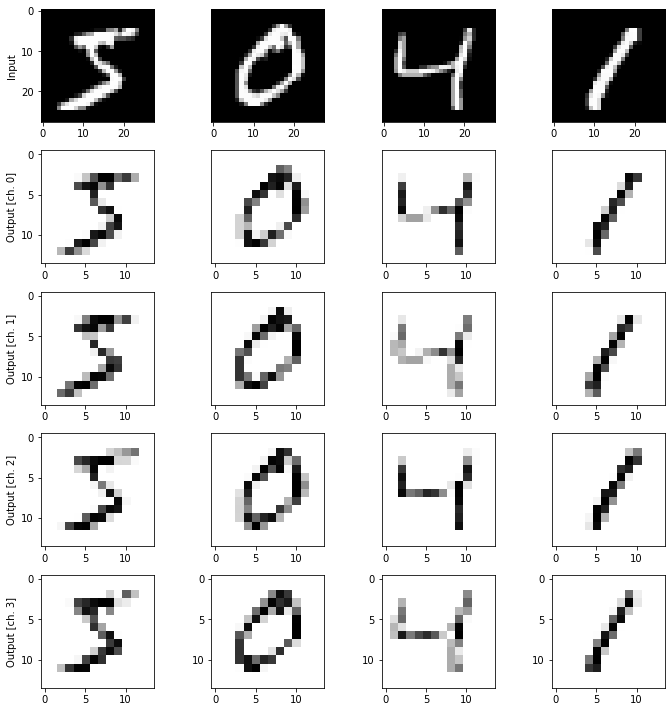

In [10]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [11]:
q_history, c_history = Train_model(100)

Epoch 1/100
13/13 - 0s - loss: 3.2212 - accuracy: 0.0600 - val_loss: 2.4344 - val_accuracy: 0.1667
Epoch 2/100
13/13 - 0s - loss: 2.4200 - accuracy: 0.1400 - val_loss: 2.2878 - val_accuracy: 0.1667
Epoch 3/100
13/13 - 0s - loss: 2.3558 - accuracy: 0.1800 - val_loss: 2.2973 - val_accuracy: 0.2000
Epoch 4/100
13/13 - 0s - loss: 2.0755 - accuracy: 0.2800 - val_loss: 2.1075 - val_accuracy: 0.2000
Epoch 5/100
13/13 - 0s - loss: 2.0708 - accuracy: 0.1800 - val_loss: 2.0618 - val_accuracy: 0.4000
Epoch 6/100
13/13 - 0s - loss: 2.0171 - accuracy: 0.3600 - val_loss: 2.1513 - val_accuracy: 0.2667
Epoch 7/100
13/13 - 0s - loss: 1.8123 - accuracy: 0.4200 - val_loss: 1.9108 - val_accuracy: 0.4333
Epoch 8/100
13/13 - 0s - loss: 1.8051 - accuracy: 0.4600 - val_loss: 1.9708 - val_accuracy: 0.3000
Epoch 9/100
13/13 - 0s - loss: 1.6562 - accuracy: 0.5400 - val_loss: 1.8395 - val_accuracy: 0.4667
Epoch 10/100
13/13 - 0s - loss: 1.4843 - accuracy: 0.6400 - val_loss: 1.9240 - val_accuracy: 0.4333
Epoch 11/

13/13 - 0s - loss: 0.1666 - accuracy: 1.0000 - val_loss: 1.1152 - val_accuracy: 0.6333
Epoch 84/100
13/13 - 0s - loss: 0.1668 - accuracy: 1.0000 - val_loss: 1.1139 - val_accuracy: 0.6333
Epoch 85/100
13/13 - 0s - loss: 0.1583 - accuracy: 1.0000 - val_loss: 1.1251 - val_accuracy: 0.5667
Epoch 86/100
13/13 - 0s - loss: 0.1647 - accuracy: 1.0000 - val_loss: 1.1175 - val_accuracy: 0.6333
Epoch 87/100
13/13 - 0s - loss: 0.1561 - accuracy: 1.0000 - val_loss: 1.1040 - val_accuracy: 0.6333
Epoch 88/100
13/13 - 0s - loss: 0.1519 - accuracy: 1.0000 - val_loss: 1.0904 - val_accuracy: 0.7000
Epoch 89/100
13/13 - 0s - loss: 0.1532 - accuracy: 1.0000 - val_loss: 1.0949 - val_accuracy: 0.7000
Epoch 90/100
13/13 - 0s - loss: 0.1439 - accuracy: 1.0000 - val_loss: 1.1152 - val_accuracy: 0.5667
Epoch 91/100
13/13 - 0s - loss: 0.1495 - accuracy: 1.0000 - val_loss: 1.0914 - val_accuracy: 0.6333
Epoch 92/100
13/13 - 0s - loss: 0.1423 - accuracy: 1.0000 - val_loss: 1.1054 - val_accuracy: 0.6333
Epoch 93/100


Epoch 66/100
13/13 - 0s - loss: 0.0370 - accuracy: 1.0000 - val_loss: 1.0016 - val_accuracy: 0.6667
Epoch 67/100
13/13 - 0s - loss: 0.0360 - accuracy: 1.0000 - val_loss: 1.0036 - val_accuracy: 0.6667
Epoch 68/100
13/13 - 0s - loss: 0.0352 - accuracy: 1.0000 - val_loss: 1.0034 - val_accuracy: 0.6667
Epoch 69/100
13/13 - 0s - loss: 0.0344 - accuracy: 1.0000 - val_loss: 1.0049 - val_accuracy: 0.6667
Epoch 70/100
13/13 - 0s - loss: 0.0335 - accuracy: 1.0000 - val_loss: 1.0031 - val_accuracy: 0.6667
Epoch 71/100
13/13 - 0s - loss: 0.0327 - accuracy: 1.0000 - val_loss: 1.0040 - val_accuracy: 0.6667
Epoch 72/100
13/13 - 0s - loss: 0.0320 - accuracy: 1.0000 - val_loss: 1.0064 - val_accuracy: 0.6667
Epoch 73/100
13/13 - 0s - loss: 0.0311 - accuracy: 1.0000 - val_loss: 1.0039 - val_accuracy: 0.6667
Epoch 74/100
13/13 - 0s - loss: 0.0304 - accuracy: 1.0000 - val_loss: 1.0014 - val_accuracy: 0.6667
Epoch 75/100
13/13 - 0s - loss: 0.0298 - accuracy: 1.0000 - val_loss: 1.0010 - val_accuracy: 0.6667


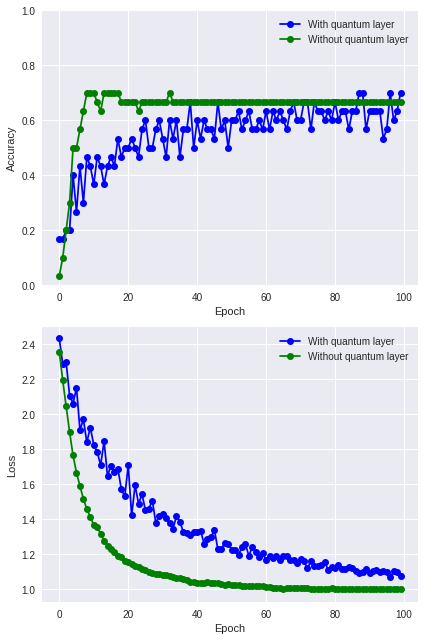

In [12]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()


<h2> Repeat = 2 </h2>

In [13]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_train_images)
    QTestI.append(q_test_images)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


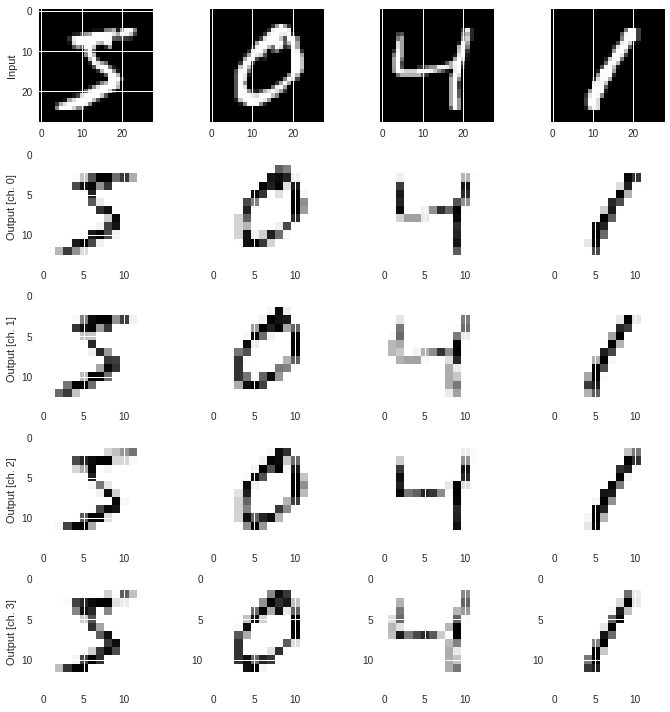

In [14]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [15]:
q_history, c_history = Train_model(100)


Epoch 1/100
13/13 - 1s - loss: 2.9915 - accuracy: 0.0800 - val_loss: 2.3817 - val_accuracy: 0.0667
Epoch 2/100
13/13 - 0s - loss: 2.5231 - accuracy: 0.0400 - val_loss: 2.2986 - val_accuracy: 0.1667
Epoch 3/100
13/13 - 0s - loss: 2.3382 - accuracy: 0.1400 - val_loss: 2.2688 - val_accuracy: 0.1667
Epoch 4/100
13/13 - 0s - loss: 2.0733 - accuracy: 0.2200 - val_loss: 2.0768 - val_accuracy: 0.1667
Epoch 5/100
13/13 - 0s - loss: 2.0845 - accuracy: 0.1600 - val_loss: 2.0485 - val_accuracy: 0.3000
Epoch 6/100
13/13 - 0s - loss: 2.0291 - accuracy: 0.3400 - val_loss: 2.1116 - val_accuracy: 0.3000
Epoch 7/100
13/13 - 0s - loss: 1.8208 - accuracy: 0.4800 - val_loss: 1.8690 - val_accuracy: 0.5000
Epoch 8/100
13/13 - 0s - loss: 1.7775 - accuracy: 0.4800 - val_loss: 1.9260 - val_accuracy: 0.3667
Epoch 9/100
13/13 - 0s - loss: 1.6193 - accuracy: 0.5600 - val_loss: 1.7968 - val_accuracy: 0.5000
Epoch 10/100
13/13 - 0s - loss: 1.4648 - accuracy: 0.7400 - val_loss: 1.8614 - val_accuracy: 0.4000
Epoch 11/

13/13 - 0s - loss: 0.1632 - accuracy: 1.0000 - val_loss: 1.0570 - val_accuracy: 0.6667
Epoch 84/100
13/13 - 0s - loss: 0.1641 - accuracy: 1.0000 - val_loss: 1.0555 - val_accuracy: 0.6667
Epoch 85/100
13/13 - 0s - loss: 0.1565 - accuracy: 1.0000 - val_loss: 1.0690 - val_accuracy: 0.6333
Epoch 86/100
13/13 - 0s - loss: 0.1620 - accuracy: 1.0000 - val_loss: 1.0466 - val_accuracy: 0.6667
Epoch 87/100
13/13 - 0s - loss: 0.1542 - accuracy: 1.0000 - val_loss: 1.0479 - val_accuracy: 0.7000
Epoch 88/100
13/13 - 0s - loss: 0.1518 - accuracy: 1.0000 - val_loss: 1.0286 - val_accuracy: 0.6667
Epoch 89/100
13/13 - 0s - loss: 0.1532 - accuracy: 1.0000 - val_loss: 1.0306 - val_accuracy: 0.7000
Epoch 90/100
13/13 - 0s - loss: 0.1420 - accuracy: 1.0000 - val_loss: 1.0482 - val_accuracy: 0.6667
Epoch 91/100
13/13 - 0s - loss: 0.1510 - accuracy: 1.0000 - val_loss: 1.0383 - val_accuracy: 0.6333
Epoch 92/100
13/13 - 0s - loss: 0.1412 - accuracy: 1.0000 - val_loss: 1.0470 - val_accuracy: 0.7000
Epoch 93/100


Epoch 66/100
13/13 - 0s - loss: 0.0362 - accuracy: 1.0000 - val_loss: 1.0082 - val_accuracy: 0.7333
Epoch 67/100
13/13 - 0s - loss: 0.0353 - accuracy: 1.0000 - val_loss: 1.0102 - val_accuracy: 0.7333
Epoch 68/100
13/13 - 0s - loss: 0.0344 - accuracy: 1.0000 - val_loss: 1.0098 - val_accuracy: 0.7333
Epoch 69/100
13/13 - 0s - loss: 0.0336 - accuracy: 1.0000 - val_loss: 1.0114 - val_accuracy: 0.7333
Epoch 70/100
13/13 - 0s - loss: 0.0328 - accuracy: 1.0000 - val_loss: 1.0097 - val_accuracy: 0.7333
Epoch 71/100
13/13 - 0s - loss: 0.0321 - accuracy: 1.0000 - val_loss: 1.0106 - val_accuracy: 0.7333
Epoch 72/100
13/13 - 0s - loss: 0.0314 - accuracy: 1.0000 - val_loss: 1.0130 - val_accuracy: 0.7333
Epoch 73/100
13/13 - 0s - loss: 0.0305 - accuracy: 1.0000 - val_loss: 1.0106 - val_accuracy: 0.7333
Epoch 74/100
13/13 - 0s - loss: 0.0298 - accuracy: 1.0000 - val_loss: 1.0080 - val_accuracy: 0.7333
Epoch 75/100
13/13 - 0s - loss: 0.0292 - accuracy: 1.0000 - val_loss: 1.0080 - val_accuracy: 0.7333


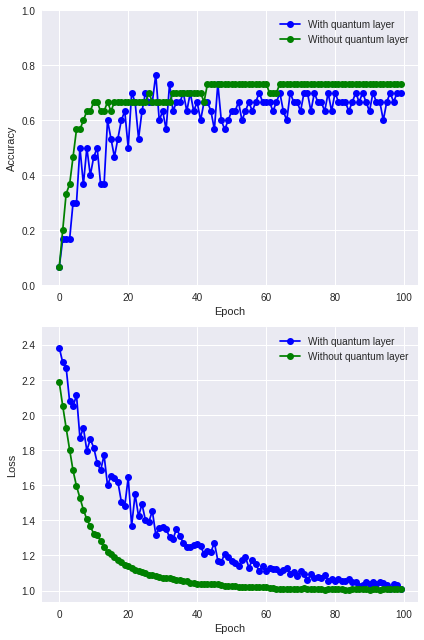

In [16]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2> Repeat = 3 </h2>

In [17]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_train_images)
    QTestI.append(q_test_images)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


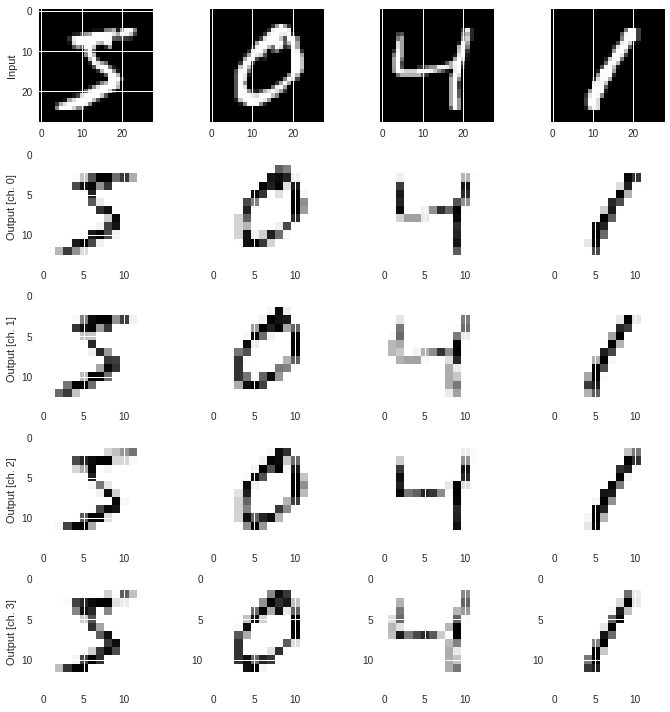

In [18]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [19]:
q_history, c_history = Train_model(100)

Epoch 1/100
13/13 - 1s - loss: 3.0213 - accuracy: 0.1200 - val_loss: 2.3535 - val_accuracy: 0.1333
Epoch 2/100
13/13 - 0s - loss: 2.4137 - accuracy: 0.1000 - val_loss: 2.2277 - val_accuracy: 0.2000
Epoch 3/100
13/13 - 0s - loss: 2.3292 - accuracy: 0.2000 - val_loss: 2.2924 - val_accuracy: 0.1333
Epoch 4/100
13/13 - 0s - loss: 2.0429 - accuracy: 0.2800 - val_loss: 2.0325 - val_accuracy: 0.2000
Epoch 5/100
13/13 - 0s - loss: 2.0561 - accuracy: 0.1600 - val_loss: 2.0141 - val_accuracy: 0.3667
Epoch 6/100
13/13 - 0s - loss: 2.0182 - accuracy: 0.3800 - val_loss: 2.0963 - val_accuracy: 0.2667
Epoch 7/100
13/13 - 0s - loss: 1.7875 - accuracy: 0.4800 - val_loss: 1.8408 - val_accuracy: 0.3333
Epoch 8/100
13/13 - 0s - loss: 1.7723 - accuracy: 0.4600 - val_loss: 1.9002 - val_accuracy: 0.3000
Epoch 9/100
13/13 - 0s - loss: 1.6241 - accuracy: 0.6400 - val_loss: 1.7837 - val_accuracy: 0.5000
Epoch 10/100
13/13 - 0s - loss: 1.4523 - accuracy: 0.6800 - val_loss: 1.8412 - val_accuracy: 0.4667
Epoch 11/

13/13 - 0s - loss: 0.1653 - accuracy: 1.0000 - val_loss: 1.0698 - val_accuracy: 0.7000
Epoch 84/100
13/13 - 0s - loss: 0.1658 - accuracy: 1.0000 - val_loss: 1.0717 - val_accuracy: 0.6333
Epoch 85/100
13/13 - 0s - loss: 0.1572 - accuracy: 1.0000 - val_loss: 1.0783 - val_accuracy: 0.5667
Epoch 86/100
13/13 - 0s - loss: 0.1634 - accuracy: 1.0000 - val_loss: 1.0668 - val_accuracy: 0.6333
Epoch 87/100
13/13 - 0s - loss: 0.1544 - accuracy: 1.0000 - val_loss: 1.0567 - val_accuracy: 0.6333
Epoch 88/100
13/13 - 0s - loss: 0.1518 - accuracy: 1.0000 - val_loss: 1.0468 - val_accuracy: 0.7000
Epoch 89/100
13/13 - 0s - loss: 0.1524 - accuracy: 1.0000 - val_loss: 1.0545 - val_accuracy: 0.7000
Epoch 90/100
13/13 - 0s - loss: 0.1420 - accuracy: 1.0000 - val_loss: 1.0606 - val_accuracy: 0.6000
Epoch 91/100
13/13 - 0s - loss: 0.1484 - accuracy: 1.0000 - val_loss: 1.0550 - val_accuracy: 0.6333
Epoch 92/100
13/13 - 0s - loss: 0.1411 - accuracy: 1.0000 - val_loss: 1.0568 - val_accuracy: 0.6333
Epoch 93/100


Epoch 66/100
13/13 - 0s - loss: 0.0370 - accuracy: 1.0000 - val_loss: 1.0050 - val_accuracy: 0.7000
Epoch 67/100
13/13 - 0s - loss: 0.0360 - accuracy: 1.0000 - val_loss: 1.0070 - val_accuracy: 0.7000
Epoch 68/100
13/13 - 0s - loss: 0.0352 - accuracy: 1.0000 - val_loss: 1.0072 - val_accuracy: 0.7000
Epoch 69/100
13/13 - 0s - loss: 0.0343 - accuracy: 1.0000 - val_loss: 1.0092 - val_accuracy: 0.7000
Epoch 70/100
13/13 - 0s - loss: 0.0335 - accuracy: 1.0000 - val_loss: 1.0086 - val_accuracy: 0.7000
Epoch 71/100
13/13 - 0s - loss: 0.0327 - accuracy: 1.0000 - val_loss: 1.0093 - val_accuracy: 0.7000
Epoch 72/100
13/13 - 0s - loss: 0.0320 - accuracy: 1.0000 - val_loss: 1.0120 - val_accuracy: 0.7000
Epoch 73/100
13/13 - 0s - loss: 0.0312 - accuracy: 1.0000 - val_loss: 1.0097 - val_accuracy: 0.7000
Epoch 74/100
13/13 - 0s - loss: 0.0304 - accuracy: 1.0000 - val_loss: 1.0076 - val_accuracy: 0.7000
Epoch 75/100
13/13 - 0s - loss: 0.0298 - accuracy: 1.0000 - val_loss: 1.0075 - val_accuracy: 0.7000


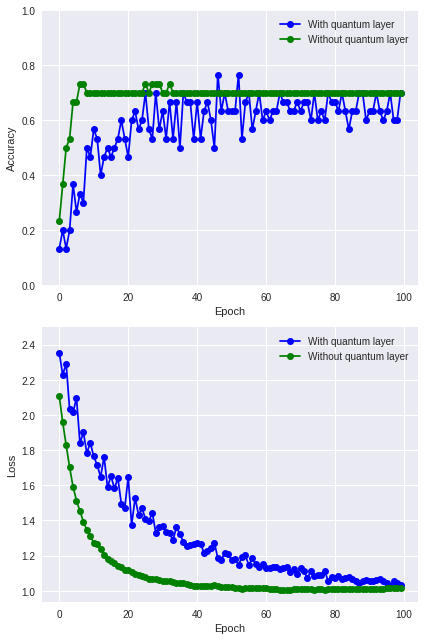

In [20]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2> Repeat = 4 </h2>

In [21]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_train_images)
    QTestI.append(q_test_images)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


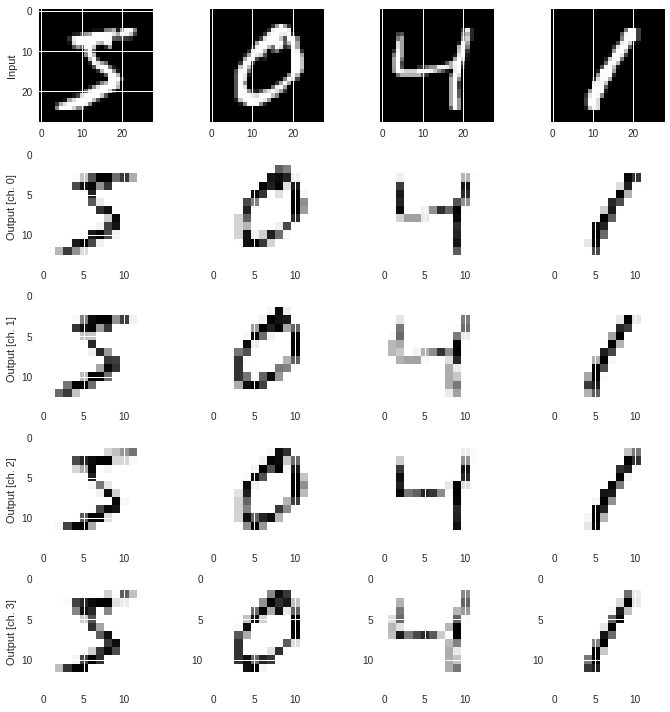

In [22]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [23]:
q_history, c_history = Train_model(100)

Epoch 1/100
13/13 - 0s - loss: 3.1944 - accuracy: 0.0800 - val_loss: 2.5352 - val_accuracy: 0.0333
Epoch 2/100
13/13 - 0s - loss: 2.5194 - accuracy: 0.1800 - val_loss: 2.3348 - val_accuracy: 0.2000
Epoch 3/100
13/13 - 0s - loss: 2.4044 - accuracy: 0.1000 - val_loss: 2.2023 - val_accuracy: 0.2000
Epoch 4/100
13/13 - 0s - loss: 2.1143 - accuracy: 0.2000 - val_loss: 2.1479 - val_accuracy: 0.0667
Epoch 5/100
13/13 - 0s - loss: 2.1084 - accuracy: 0.1600 - val_loss: 2.0642 - val_accuracy: 0.3333
Epoch 6/100
13/13 - 0s - loss: 2.0531 - accuracy: 0.3000 - val_loss: 2.1222 - val_accuracy: 0.3000
Epoch 7/100
13/13 - 0s - loss: 1.8541 - accuracy: 0.4000 - val_loss: 1.8862 - val_accuracy: 0.3333
Epoch 8/100
13/13 - 0s - loss: 1.8097 - accuracy: 0.4600 - val_loss: 1.9245 - val_accuracy: 0.4000
Epoch 9/100
13/13 - 0s - loss: 1.6656 - accuracy: 0.5800 - val_loss: 1.8097 - val_accuracy: 0.5667
Epoch 10/100
13/13 - 0s - loss: 1.4934 - accuracy: 0.6800 - val_loss: 1.8775 - val_accuracy: 0.4333
Epoch 11/

13/13 - 0s - loss: 0.1677 - accuracy: 1.0000 - val_loss: 1.0294 - val_accuracy: 0.6667
Epoch 84/100
13/13 - 0s - loss: 0.1674 - accuracy: 1.0000 - val_loss: 1.0413 - val_accuracy: 0.6333
Epoch 85/100
13/13 - 0s - loss: 0.1588 - accuracy: 1.0000 - val_loss: 1.0429 - val_accuracy: 0.6333
Epoch 86/100
13/13 - 0s - loss: 0.1648 - accuracy: 1.0000 - val_loss: 1.0324 - val_accuracy: 0.6333
Epoch 87/100
13/13 - 0s - loss: 0.1558 - accuracy: 1.0000 - val_loss: 1.0286 - val_accuracy: 0.6667
Epoch 88/100
13/13 - 0s - loss: 0.1524 - accuracy: 1.0000 - val_loss: 1.0086 - val_accuracy: 0.7000
Epoch 89/100
13/13 - 0s - loss: 0.1534 - accuracy: 1.0000 - val_loss: 1.0102 - val_accuracy: 0.7000
Epoch 90/100
13/13 - 0s - loss: 0.1443 - accuracy: 1.0000 - val_loss: 1.0314 - val_accuracy: 0.6000
Epoch 91/100
13/13 - 0s - loss: 0.1498 - accuracy: 1.0000 - val_loss: 1.0122 - val_accuracy: 0.7000
Epoch 92/100
13/13 - 0s - loss: 0.1421 - accuracy: 1.0000 - val_loss: 1.0260 - val_accuracy: 0.6667
Epoch 93/100


Epoch 66/100
13/13 - 0s - loss: 0.0377 - accuracy: 1.0000 - val_loss: 0.9588 - val_accuracy: 0.7667
Epoch 67/100
13/13 - 0s - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.9598 - val_accuracy: 0.7667
Epoch 68/100
13/13 - 0s - loss: 0.0358 - accuracy: 1.0000 - val_loss: 0.9594 - val_accuracy: 0.7667
Epoch 69/100
13/13 - 0s - loss: 0.0350 - accuracy: 1.0000 - val_loss: 0.9607 - val_accuracy: 0.7667
Epoch 70/100
13/13 - 0s - loss: 0.0341 - accuracy: 1.0000 - val_loss: 0.9598 - val_accuracy: 0.7667
Epoch 71/100
13/13 - 0s - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.9596 - val_accuracy: 0.7667
Epoch 72/100
13/13 - 0s - loss: 0.0326 - accuracy: 1.0000 - val_loss: 0.9615 - val_accuracy: 0.7667
Epoch 73/100
13/13 - 0s - loss: 0.0317 - accuracy: 1.0000 - val_loss: 0.9590 - val_accuracy: 0.7667
Epoch 74/100
13/13 - 0s - loss: 0.0310 - accuracy: 1.0000 - val_loss: 0.9567 - val_accuracy: 0.7667
Epoch 75/100
13/13 - 0s - loss: 0.0304 - accuracy: 1.0000 - val_loss: 0.9561 - val_accuracy: 0.7667


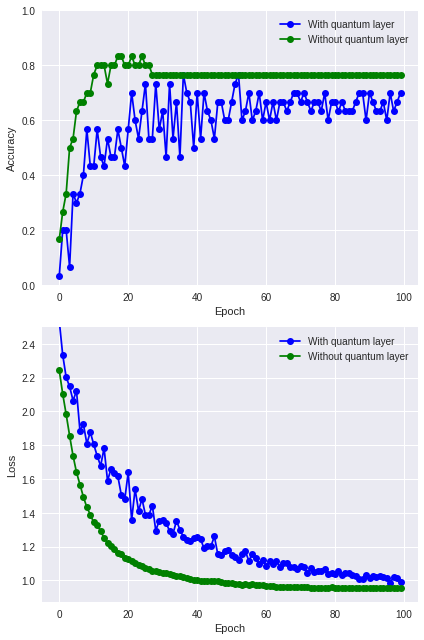

In [24]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2> Repeat = 5<h2>

In [25]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_train_images)
    QTestI.append(q_test_images)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


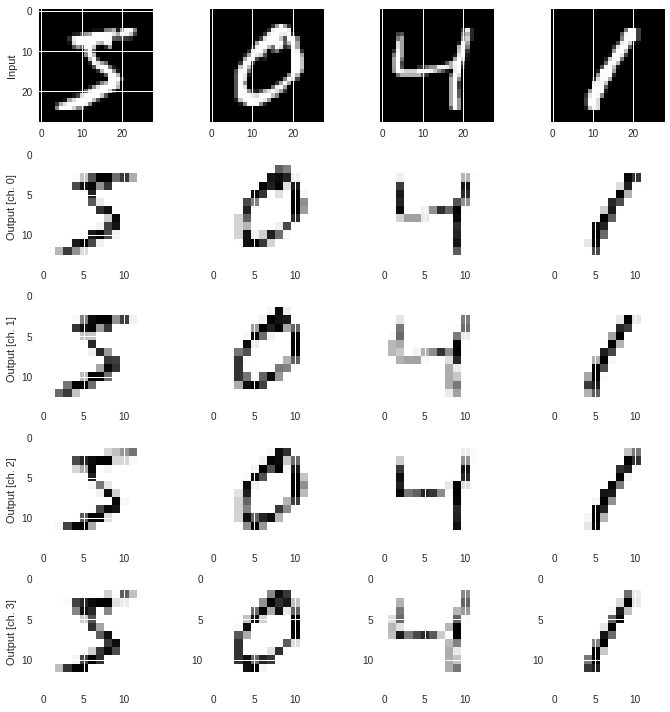

In [26]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [27]:
q_history, c_history = Train_model(100)

Epoch 1/100
13/13 - 0s - loss: 3.1375 - accuracy: 0.0800 - val_loss: 2.4324 - val_accuracy: 0.1333
Epoch 2/100
13/13 - 0s - loss: 2.6500 - accuracy: 0.0400 - val_loss: 2.4787 - val_accuracy: 0.0667
Epoch 3/100
13/13 - 0s - loss: 2.3350 - accuracy: 0.1800 - val_loss: 2.4745 - val_accuracy: 0.1000
Epoch 4/100
13/13 - 0s - loss: 2.1237 - accuracy: 0.2000 - val_loss: 2.1723 - val_accuracy: 0.1000
Epoch 5/100
13/13 - 0s - loss: 2.0977 - accuracy: 0.2200 - val_loss: 2.2199 - val_accuracy: 0.2667
Epoch 6/100
13/13 - 0s - loss: 2.0531 - accuracy: 0.4000 - val_loss: 2.2233 - val_accuracy: 0.2333
Epoch 7/100
13/13 - 0s - loss: 1.8504 - accuracy: 0.4200 - val_loss: 1.9917 - val_accuracy: 0.2667
Epoch 8/100
13/13 - 0s - loss: 1.8199 - accuracy: 0.4200 - val_loss: 2.0402 - val_accuracy: 0.2667
Epoch 9/100
13/13 - 0s - loss: 1.6844 - accuracy: 0.4600 - val_loss: 1.9095 - val_accuracy: 0.4000
Epoch 10/100
13/13 - 0s - loss: 1.5078 - accuracy: 0.6200 - val_loss: 2.0159 - val_accuracy: 0.2667
Epoch 11/

13/13 - 0s - loss: 0.1677 - accuracy: 1.0000 - val_loss: 1.1144 - val_accuracy: 0.6667
Epoch 84/100
13/13 - 0s - loss: 0.1682 - accuracy: 1.0000 - val_loss: 1.1257 - val_accuracy: 0.6667
Epoch 85/100
13/13 - 0s - loss: 0.1584 - accuracy: 1.0000 - val_loss: 1.1318 - val_accuracy: 0.6333
Epoch 86/100
13/13 - 0s - loss: 0.1656 - accuracy: 1.0000 - val_loss: 1.1216 - val_accuracy: 0.6667
Epoch 87/100
13/13 - 0s - loss: 0.1572 - accuracy: 1.0000 - val_loss: 1.1046 - val_accuracy: 0.6667
Epoch 88/100
13/13 - 0s - loss: 0.1522 - accuracy: 1.0000 - val_loss: 1.0948 - val_accuracy: 0.7000
Epoch 89/100
13/13 - 0s - loss: 0.1537 - accuracy: 1.0000 - val_loss: 1.0970 - val_accuracy: 0.7000
Epoch 90/100
13/13 - 0s - loss: 0.1447 - accuracy: 1.0000 - val_loss: 1.1154 - val_accuracy: 0.6333
Epoch 91/100
13/13 - 0s - loss: 0.1503 - accuracy: 1.0000 - val_loss: 1.0984 - val_accuracy: 0.6667
Epoch 92/100
13/13 - 0s - loss: 0.1422 - accuracy: 1.0000 - val_loss: 1.1025 - val_accuracy: 0.6667
Epoch 93/100


Epoch 66/100
13/13 - 0s - loss: 0.0358 - accuracy: 1.0000 - val_loss: 1.0109 - val_accuracy: 0.7333
Epoch 67/100
13/13 - 0s - loss: 0.0349 - accuracy: 1.0000 - val_loss: 1.0129 - val_accuracy: 0.7333
Epoch 68/100
13/13 - 0s - loss: 0.0341 - accuracy: 1.0000 - val_loss: 1.0129 - val_accuracy: 0.7000
Epoch 69/100
13/13 - 0s - loss: 0.0333 - accuracy: 1.0000 - val_loss: 1.0150 - val_accuracy: 0.7000
Epoch 70/100
13/13 - 0s - loss: 0.0324 - accuracy: 1.0000 - val_loss: 1.0139 - val_accuracy: 0.7000
Epoch 71/100
13/13 - 0s - loss: 0.0317 - accuracy: 1.0000 - val_loss: 1.0141 - val_accuracy: 0.7000
Epoch 72/100
13/13 - 0s - loss: 0.0310 - accuracy: 1.0000 - val_loss: 1.0174 - val_accuracy: 0.7000
Epoch 73/100
13/13 - 0s - loss: 0.0302 - accuracy: 1.0000 - val_loss: 1.0151 - val_accuracy: 0.7000
Epoch 74/100
13/13 - 0s - loss: 0.0295 - accuracy: 1.0000 - val_loss: 1.0124 - val_accuracy: 0.7000
Epoch 75/100
13/13 - 0s - loss: 0.0289 - accuracy: 1.0000 - val_loss: 1.0120 - val_accuracy: 0.7000


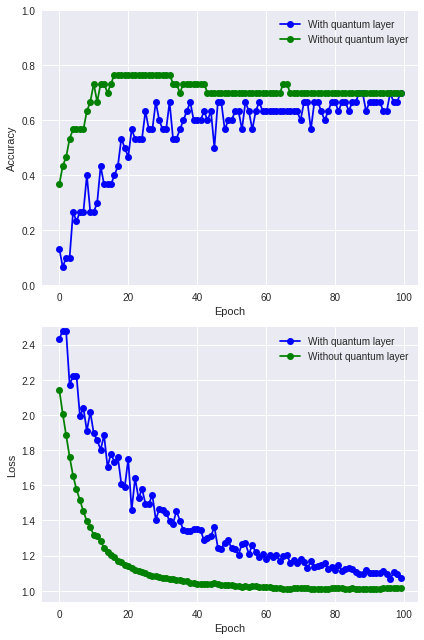

In [28]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 6</h2>

In [29]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_train_images)
    QTestI.append(q_test_images)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


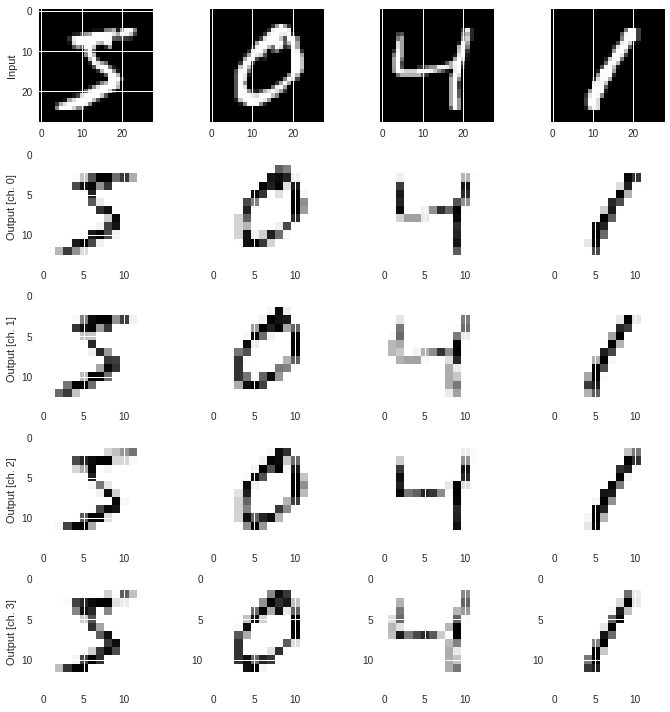

In [30]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [31]:
q_history, c_history = Train_model(100)

Epoch 1/100
13/13 - 0s - loss: 2.8860 - accuracy: 0.0600 - val_loss: 2.2328 - val_accuracy: 0.2000
Epoch 2/100
13/13 - 0s - loss: 2.5424 - accuracy: 0.1000 - val_loss: 2.2903 - val_accuracy: 0.1000
Epoch 3/100
13/13 - 0s - loss: 2.3241 - accuracy: 0.1600 - val_loss: 2.2799 - val_accuracy: 0.1667
Epoch 4/100
13/13 - 0s - loss: 2.0578 - accuracy: 0.2400 - val_loss: 2.0529 - val_accuracy: 0.1667
Epoch 5/100
13/13 - 0s - loss: 2.0670 - accuracy: 0.2200 - val_loss: 2.0431 - val_accuracy: 0.3000
Epoch 6/100
13/13 - 0s - loss: 2.0122 - accuracy: 0.3600 - val_loss: 2.0854 - val_accuracy: 0.3000
Epoch 7/100
13/13 - 0s - loss: 1.8180 - accuracy: 0.4400 - val_loss: 1.8760 - val_accuracy: 0.4333
Epoch 8/100
13/13 - 0s - loss: 1.7930 - accuracy: 0.4800 - val_loss: 1.9136 - val_accuracy: 0.3333
Epoch 9/100
13/13 - 0s - loss: 1.6354 - accuracy: 0.6000 - val_loss: 1.7929 - val_accuracy: 0.5000
Epoch 10/100
13/13 - 0s - loss: 1.4727 - accuracy: 0.7000 - val_loss: 1.8824 - val_accuracy: 0.4000
Epoch 11/

13/13 - 0s - loss: 0.1651 - accuracy: 1.0000 - val_loss: 1.0716 - val_accuracy: 0.7000
Epoch 84/100
13/13 - 0s - loss: 0.1659 - accuracy: 1.0000 - val_loss: 1.0751 - val_accuracy: 0.6667
Epoch 85/100
13/13 - 0s - loss: 0.1565 - accuracy: 1.0000 - val_loss: 1.0804 - val_accuracy: 0.6000
Epoch 86/100
13/13 - 0s - loss: 0.1625 - accuracy: 1.0000 - val_loss: 1.0659 - val_accuracy: 0.7000
Epoch 87/100
13/13 - 0s - loss: 0.1562 - accuracy: 1.0000 - val_loss: 1.0583 - val_accuracy: 0.7000
Epoch 88/100
13/13 - 0s - loss: 0.1524 - accuracy: 1.0000 - val_loss: 1.0484 - val_accuracy: 0.7000
Epoch 89/100
13/13 - 0s - loss: 0.1536 - accuracy: 1.0000 - val_loss: 1.0512 - val_accuracy: 0.6667
Epoch 90/100
13/13 - 0s - loss: 0.1422 - accuracy: 1.0000 - val_loss: 1.0633 - val_accuracy: 0.6333
Epoch 91/100
13/13 - 0s - loss: 0.1500 - accuracy: 1.0000 - val_loss: 1.0519 - val_accuracy: 0.6333
Epoch 92/100
13/13 - 0s - loss: 0.1419 - accuracy: 1.0000 - val_loss: 1.0581 - val_accuracy: 0.7000
Epoch 93/100


Epoch 66/100
13/13 - 0s - loss: 0.0360 - accuracy: 1.0000 - val_loss: 0.9626 - val_accuracy: 0.7333
Epoch 67/100
13/13 - 0s - loss: 0.0351 - accuracy: 1.0000 - val_loss: 0.9645 - val_accuracy: 0.7333
Epoch 68/100
13/13 - 0s - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.9645 - val_accuracy: 0.7333
Epoch 69/100
13/13 - 0s - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.9655 - val_accuracy: 0.7333
Epoch 70/100
13/13 - 0s - loss: 0.0326 - accuracy: 1.0000 - val_loss: 0.9644 - val_accuracy: 0.7333
Epoch 71/100
13/13 - 0s - loss: 0.0319 - accuracy: 1.0000 - val_loss: 0.9651 - val_accuracy: 0.7333
Epoch 72/100
13/13 - 0s - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.9670 - val_accuracy: 0.7333
Epoch 73/100
13/13 - 0s - loss: 0.0303 - accuracy: 1.0000 - val_loss: 0.9648 - val_accuracy: 0.7333
Epoch 74/100
13/13 - 0s - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.9625 - val_accuracy: 0.7333
Epoch 75/100
13/13 - 0s - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.9624 - val_accuracy: 0.7333


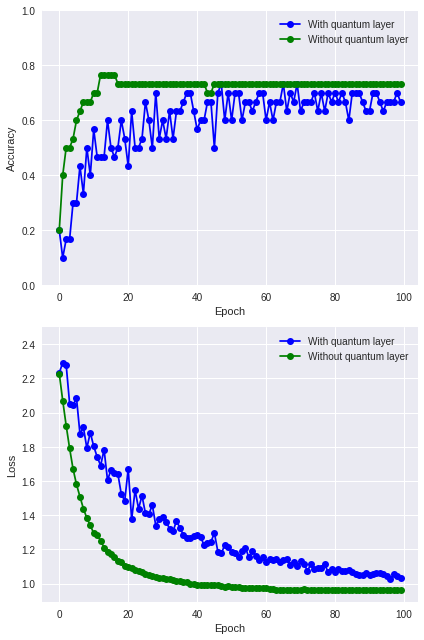

In [32]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 7 </h2> 

In [33]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_train_images)
    QTestI.append(q_test_images)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


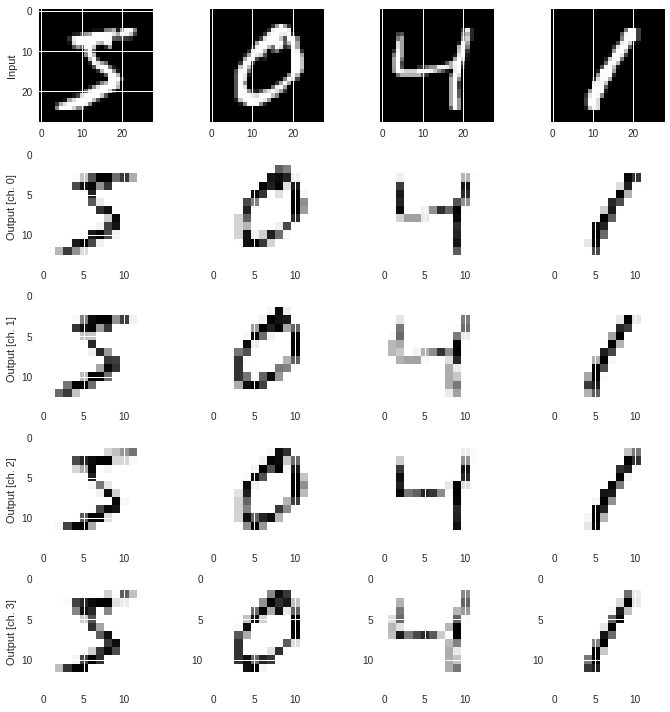

In [34]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [35]:
q_history, c_history = Train_model(100)

Epoch 1/100
13/13 - 1s - loss: 3.1941 - accuracy: 0.1000 - val_loss: 2.4250 - val_accuracy: 0.0667
Epoch 2/100
13/13 - 0s - loss: 2.4564 - accuracy: 0.1200 - val_loss: 2.2772 - val_accuracy: 0.2000
Epoch 3/100
13/13 - 0s - loss: 2.3847 - accuracy: 0.1800 - val_loss: 2.2558 - val_accuracy: 0.1333
Epoch 4/100
13/13 - 0s - loss: 2.1042 - accuracy: 0.2000 - val_loss: 2.0636 - val_accuracy: 0.1667
Epoch 5/100
13/13 - 0s - loss: 2.0996 - accuracy: 0.1800 - val_loss: 2.0207 - val_accuracy: 0.3333
Epoch 6/100
13/13 - 0s - loss: 2.0428 - accuracy: 0.3400 - val_loss: 2.0948 - val_accuracy: 0.2667
Epoch 7/100
13/13 - 0s - loss: 1.8337 - accuracy: 0.3800 - val_loss: 1.8307 - val_accuracy: 0.4333
Epoch 8/100
13/13 - 0s - loss: 1.8073 - accuracy: 0.4400 - val_loss: 1.8856 - val_accuracy: 0.3000
Epoch 9/100
13/13 - 0s - loss: 1.6745 - accuracy: 0.4800 - val_loss: 1.7771 - val_accuracy: 0.5667
Epoch 10/100
13/13 - 0s - loss: 1.4877 - accuracy: 0.6800 - val_loss: 1.8266 - val_accuracy: 0.5000
Epoch 11/

13/13 - 0s - loss: 0.1690 - accuracy: 1.0000 - val_loss: 0.9928 - val_accuracy: 0.7000
Epoch 84/100
13/13 - 0s - loss: 0.1704 - accuracy: 1.0000 - val_loss: 0.9991 - val_accuracy: 0.6333
Epoch 85/100
13/13 - 0s - loss: 0.1605 - accuracy: 1.0000 - val_loss: 1.0186 - val_accuracy: 0.6333
Epoch 86/100
13/13 - 0s - loss: 0.1666 - accuracy: 1.0000 - val_loss: 0.9991 - val_accuracy: 0.6333
Epoch 87/100
13/13 - 0s - loss: 0.1591 - accuracy: 1.0000 - val_loss: 0.9919 - val_accuracy: 0.6667
Epoch 88/100
13/13 - 0s - loss: 0.1537 - accuracy: 1.0000 - val_loss: 0.9772 - val_accuracy: 0.6667
Epoch 89/100
13/13 - 0s - loss: 0.1553 - accuracy: 1.0000 - val_loss: 0.9793 - val_accuracy: 0.6667
Epoch 90/100
13/13 - 0s - loss: 0.1450 - accuracy: 1.0000 - val_loss: 1.0005 - val_accuracy: 0.6333
Epoch 91/100
13/13 - 0s - loss: 0.1526 - accuracy: 1.0000 - val_loss: 0.9789 - val_accuracy: 0.7000
Epoch 92/100
13/13 - 0s - loss: 0.1445 - accuracy: 1.0000 - val_loss: 0.9939 - val_accuracy: 0.6667
Epoch 93/100


Epoch 66/100
13/13 - 0s - loss: 0.0379 - accuracy: 1.0000 - val_loss: 0.9036 - val_accuracy: 0.7000
Epoch 67/100
13/13 - 0s - loss: 0.0369 - accuracy: 1.0000 - val_loss: 0.9048 - val_accuracy: 0.7000
Epoch 68/100
13/13 - 0s - loss: 0.0361 - accuracy: 1.0000 - val_loss: 0.9042 - val_accuracy: 0.7000
Epoch 69/100
13/13 - 0s - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.9054 - val_accuracy: 0.7000
Epoch 70/100
13/13 - 0s - loss: 0.0343 - accuracy: 1.0000 - val_loss: 0.9041 - val_accuracy: 0.7000
Epoch 71/100
13/13 - 0s - loss: 0.0336 - accuracy: 1.0000 - val_loss: 0.9041 - val_accuracy: 0.7000
Epoch 72/100
13/13 - 0s - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.9059 - val_accuracy: 0.7000
Epoch 73/100
13/13 - 0s - loss: 0.0319 - accuracy: 1.0000 - val_loss: 0.9035 - val_accuracy: 0.7000
Epoch 74/100
13/13 - 0s - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.9013 - val_accuracy: 0.7000
Epoch 75/100
13/13 - 0s - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.9006 - val_accuracy: 0.7000


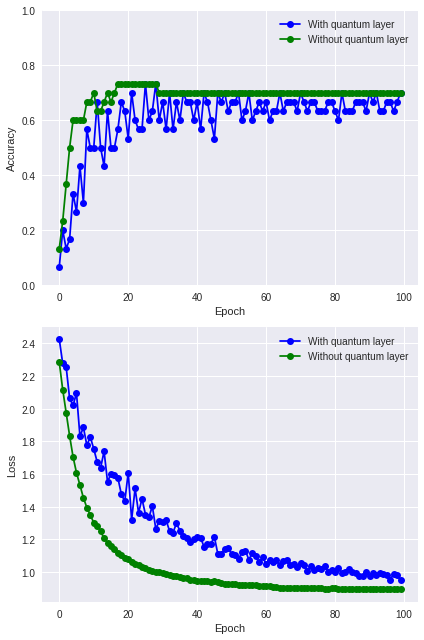

In [36]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 8</h2>

In [37]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_train_images)
    QTestI.append(q_test_images)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


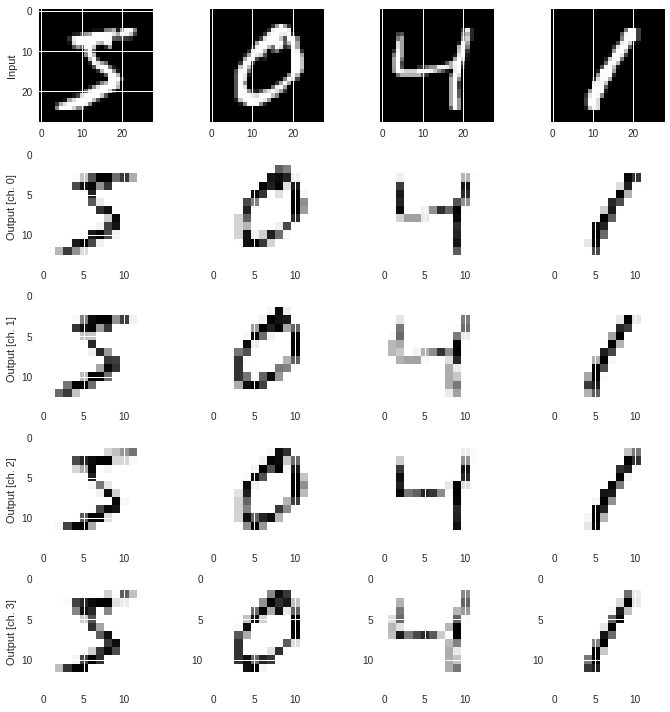

In [38]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [39]:
q_history, c_history = Train_model(100)

Epoch 1/100
13/13 - 0s - loss: 2.9823 - accuracy: 0.1400 - val_loss: 2.3908 - val_accuracy: 0.0667
Epoch 2/100
13/13 - 0s - loss: 2.5666 - accuracy: 0.1200 - val_loss: 2.2993 - val_accuracy: 0.2667
Epoch 3/100
13/13 - 0s - loss: 2.3079 - accuracy: 0.1400 - val_loss: 2.3219 - val_accuracy: 0.1667
Epoch 4/100
13/13 - 0s - loss: 2.0556 - accuracy: 0.3000 - val_loss: 2.0527 - val_accuracy: 0.2333
Epoch 5/100
13/13 - 0s - loss: 2.0659 - accuracy: 0.2200 - val_loss: 2.0577 - val_accuracy: 0.3000
Epoch 6/100
13/13 - 0s - loss: 2.0064 - accuracy: 0.3400 - val_loss: 2.1014 - val_accuracy: 0.3000
Epoch 7/100
13/13 - 0s - loss: 1.8104 - accuracy: 0.4400 - val_loss: 1.8715 - val_accuracy: 0.3667
Epoch 8/100
13/13 - 0s - loss: 1.7947 - accuracy: 0.4000 - val_loss: 1.9279 - val_accuracy: 0.3667
Epoch 9/100
13/13 - 0s - loss: 1.6481 - accuracy: 0.5400 - val_loss: 1.7934 - val_accuracy: 0.6000
Epoch 10/100
13/13 - 0s - loss: 1.4744 - accuracy: 0.7000 - val_loss: 1.8885 - val_accuracy: 0.4000
Epoch 11/

13/13 - 0s - loss: 0.1704 - accuracy: 1.0000 - val_loss: 1.0488 - val_accuracy: 0.7000
Epoch 84/100
13/13 - 0s - loss: 0.1700 - accuracy: 1.0000 - val_loss: 1.0633 - val_accuracy: 0.7000
Epoch 85/100
13/13 - 0s - loss: 0.1616 - accuracy: 1.0000 - val_loss: 1.0626 - val_accuracy: 0.6333
Epoch 86/100
13/13 - 0s - loss: 0.1664 - accuracy: 1.0000 - val_loss: 1.0530 - val_accuracy: 0.6667
Epoch 87/100
13/13 - 0s - loss: 0.1588 - accuracy: 1.0000 - val_loss: 1.0453 - val_accuracy: 0.6667
Epoch 88/100
13/13 - 0s - loss: 0.1549 - accuracy: 1.0000 - val_loss: 1.0282 - val_accuracy: 0.7333
Epoch 89/100
13/13 - 0s - loss: 0.1573 - accuracy: 1.0000 - val_loss: 1.0318 - val_accuracy: 0.7333
Epoch 90/100
13/13 - 0s - loss: 0.1470 - accuracy: 1.0000 - val_loss: 1.0500 - val_accuracy: 0.6667
Epoch 91/100
13/13 - 0s - loss: 0.1544 - accuracy: 1.0000 - val_loss: 1.0288 - val_accuracy: 0.7000
Epoch 92/100
13/13 - 0s - loss: 0.1445 - accuracy: 1.0000 - val_loss: 1.0474 - val_accuracy: 0.7000
Epoch 93/100


Epoch 66/100
13/13 - 0s - loss: 0.0386 - accuracy: 1.0000 - val_loss: 1.0069 - val_accuracy: 0.7333
Epoch 67/100
13/13 - 0s - loss: 0.0376 - accuracy: 1.0000 - val_loss: 1.0084 - val_accuracy: 0.7333
Epoch 68/100
13/13 - 0s - loss: 0.0367 - accuracy: 1.0000 - val_loss: 1.0083 - val_accuracy: 0.7333
Epoch 69/100
13/13 - 0s - loss: 0.0358 - accuracy: 1.0000 - val_loss: 1.0103 - val_accuracy: 0.7333
Epoch 70/100
13/13 - 0s - loss: 0.0349 - accuracy: 1.0000 - val_loss: 1.0095 - val_accuracy: 0.7333
Epoch 71/100
13/13 - 0s - loss: 0.0342 - accuracy: 1.0000 - val_loss: 1.0095 - val_accuracy: 0.7333
Epoch 72/100
13/13 - 0s - loss: 0.0334 - accuracy: 1.0000 - val_loss: 1.0123 - val_accuracy: 0.7000
Epoch 73/100
13/13 - 0s - loss: 0.0325 - accuracy: 1.0000 - val_loss: 1.0101 - val_accuracy: 0.7000
Epoch 74/100
13/13 - 0s - loss: 0.0318 - accuracy: 1.0000 - val_loss: 1.0078 - val_accuracy: 0.7333
Epoch 75/100
13/13 - 0s - loss: 0.0311 - accuracy: 1.0000 - val_loss: 1.0074 - val_accuracy: 0.7333


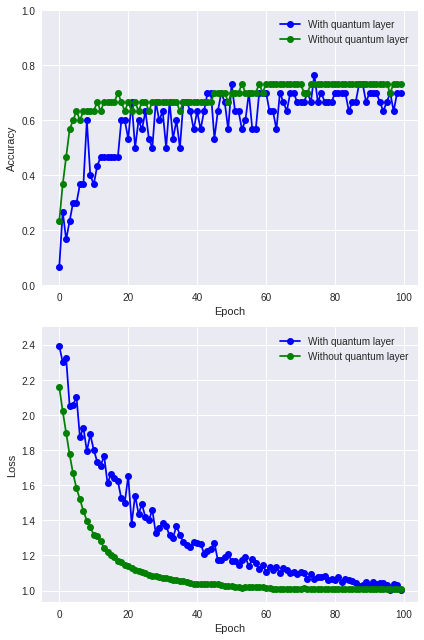

In [40]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 9</h2>

In [41]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_train_images)
    QTestI.append(q_test_images)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


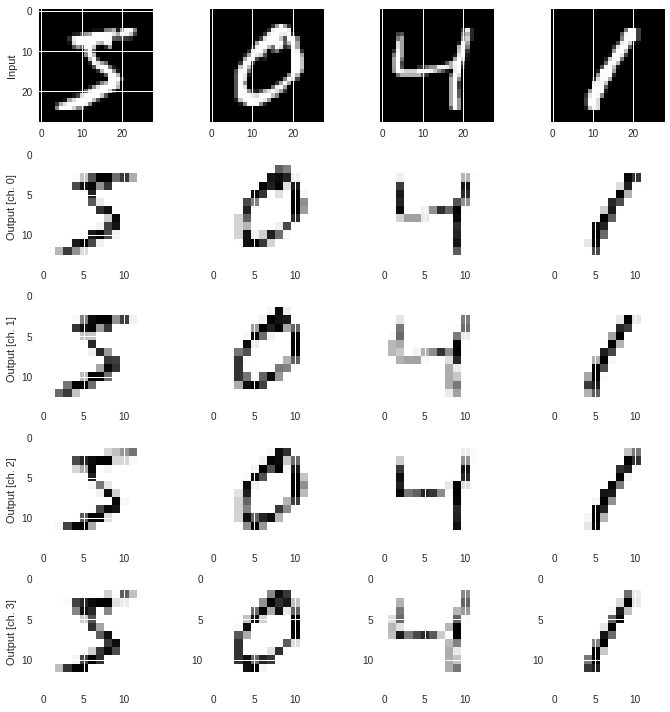

In [42]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [43]:
q_history, c_history = Train_model(100)

Epoch 1/100
13/13 - 0s - loss: 3.1052 - accuracy: 0.1200 - val_loss: 2.4457 - val_accuracy: 0.0333
Epoch 2/100
13/13 - 0s - loss: 2.4390 - accuracy: 0.1200 - val_loss: 2.2043 - val_accuracy: 0.2000
Epoch 3/100
13/13 - 0s - loss: 2.3783 - accuracy: 0.1400 - val_loss: 2.2711 - val_accuracy: 0.1667
Epoch 4/100
13/13 - 0s - loss: 2.0812 - accuracy: 0.2600 - val_loss: 2.0823 - val_accuracy: 0.1667
Epoch 5/100
13/13 - 0s - loss: 2.1112 - accuracy: 0.2200 - val_loss: 2.0085 - val_accuracy: 0.3333
Epoch 6/100
13/13 - 0s - loss: 2.0293 - accuracy: 0.3000 - val_loss: 2.1188 - val_accuracy: 0.2000
Epoch 7/100
13/13 - 0s - loss: 1.8192 - accuracy: 0.4400 - val_loss: 1.8567 - val_accuracy: 0.3667
Epoch 8/100
13/13 - 0s - loss: 1.8026 - accuracy: 0.4000 - val_loss: 1.9213 - val_accuracy: 0.2333
Epoch 9/100
13/13 - 0s - loss: 1.6371 - accuracy: 0.6200 - val_loss: 1.7815 - val_accuracy: 0.4667
Epoch 10/100
13/13 - 0s - loss: 1.4719 - accuracy: 0.6800 - val_loss: 1.8714 - val_accuracy: 0.4000
Epoch 11/

13/13 - 0s - loss: 0.1656 - accuracy: 1.0000 - val_loss: 1.0759 - val_accuracy: 0.7000
Epoch 84/100
13/13 - 0s - loss: 0.1654 - accuracy: 1.0000 - val_loss: 1.0836 - val_accuracy: 0.7000
Epoch 85/100
13/13 - 0s - loss: 0.1572 - accuracy: 1.0000 - val_loss: 1.0862 - val_accuracy: 0.6333
Epoch 86/100
13/13 - 0s - loss: 0.1646 - accuracy: 1.0000 - val_loss: 1.0758 - val_accuracy: 0.6667
Epoch 87/100
13/13 - 0s - loss: 0.1565 - accuracy: 1.0000 - val_loss: 1.0655 - val_accuracy: 0.6667
Epoch 88/100
13/13 - 0s - loss: 0.1518 - accuracy: 1.0000 - val_loss: 1.0538 - val_accuracy: 0.7000
Epoch 89/100
13/13 - 0s - loss: 0.1536 - accuracy: 1.0000 - val_loss: 1.0556 - val_accuracy: 0.7000
Epoch 90/100
13/13 - 0s - loss: 0.1426 - accuracy: 1.0000 - val_loss: 1.0743 - val_accuracy: 0.6333
Epoch 91/100
13/13 - 0s - loss: 0.1498 - accuracy: 1.0000 - val_loss: 1.0533 - val_accuracy: 0.7000
Epoch 92/100
13/13 - 0s - loss: 0.1428 - accuracy: 1.0000 - val_loss: 1.0658 - val_accuracy: 0.6667
Epoch 93/100


Epoch 66/100
13/13 - 0s - loss: 0.0357 - accuracy: 1.0000 - val_loss: 0.9465 - val_accuracy: 0.7333
Epoch 67/100
13/13 - 0s - loss: 0.0347 - accuracy: 1.0000 - val_loss: 0.9483 - val_accuracy: 0.7333
Epoch 68/100
13/13 - 0s - loss: 0.0339 - accuracy: 1.0000 - val_loss: 0.9480 - val_accuracy: 0.7333
Epoch 69/100
13/13 - 0s - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.9495 - val_accuracy: 0.7333
Epoch 70/100
13/13 - 0s - loss: 0.0323 - accuracy: 1.0000 - val_loss: 0.9479 - val_accuracy: 0.7333
Epoch 71/100
13/13 - 0s - loss: 0.0316 - accuracy: 1.0000 - val_loss: 0.9484 - val_accuracy: 0.7333
Epoch 72/100
13/13 - 0s - loss: 0.0309 - accuracy: 1.0000 - val_loss: 0.9503 - val_accuracy: 0.7333
Epoch 73/100
13/13 - 0s - loss: 0.0301 - accuracy: 1.0000 - val_loss: 0.9478 - val_accuracy: 0.7333
Epoch 74/100
13/13 - 0s - loss: 0.0294 - accuracy: 1.0000 - val_loss: 0.9457 - val_accuracy: 0.7333
Epoch 75/100
13/13 - 0s - loss: 0.0288 - accuracy: 1.0000 - val_loss: 0.9453 - val_accuracy: 0.7333


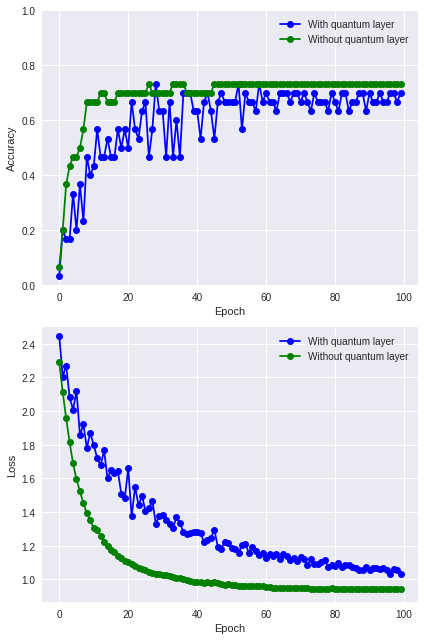

In [44]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 10</h2>

In [45]:

QTrainI = []
QTestI = []

for i in range(10):    
    q_train_images, q_test_images =  Process(2) # Repeat Process(repeat)

    QTrainI.append(q_train_images)
    QTestI.append(q_test_images)

QTrainI = tf.convert_to_tensor(QTrainI)

QTestI = tf.convert_to_tensor(QTestI)

q_train_images = tf.math.reduce_mean(QTrainI, axis = 0)
q_test_images = tf.math.reduce_mean(QTestI, axis = 0)
  

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:
Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


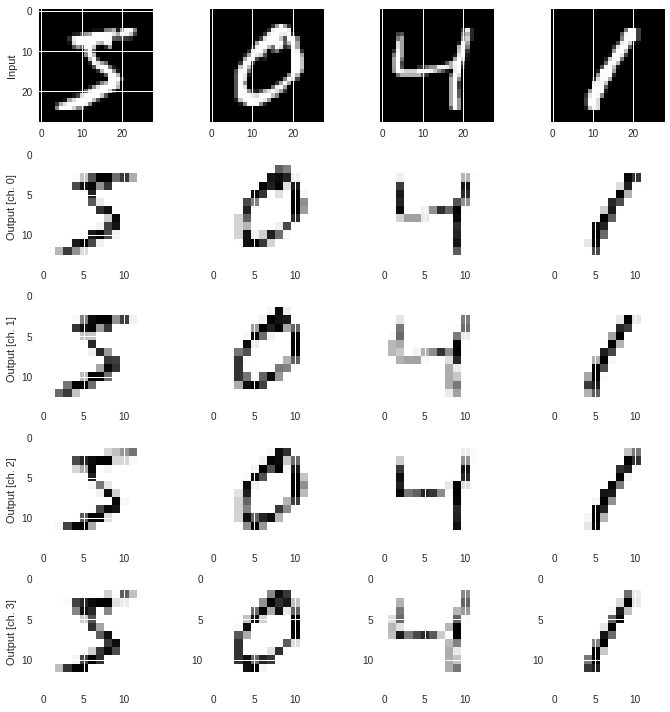

In [46]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [47]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 0s - loss: 3.2043 - accuracy: 0.0600 - val_loss: 2.6325 - val_accuracy: 0.0333
Epoch 2/50
13/13 - 0s - loss: 2.5503 - accuracy: 0.1200 - val_loss: 2.3355 - val_accuracy: 0.2000
Epoch 3/50
13/13 - 0s - loss: 2.4483 - accuracy: 0.1400 - val_loss: 2.2834 - val_accuracy: 0.1333
Epoch 4/50
13/13 - 0s - loss: 2.1604 - accuracy: 0.2200 - val_loss: 2.1763 - val_accuracy: 0.1000
Epoch 5/50
13/13 - 0s - loss: 2.1732 - accuracy: 0.1400 - val_loss: 2.0606 - val_accuracy: 0.4333
Epoch 6/50
13/13 - 0s - loss: 2.0752 - accuracy: 0.3200 - val_loss: 2.1601 - val_accuracy: 0.1000
Epoch 7/50
13/13 - 0s - loss: 1.8853 - accuracy: 0.3800 - val_loss: 1.9213 - val_accuracy: 0.4333
Epoch 8/50
13/13 - 0s - loss: 1.8486 - accuracy: 0.4600 - val_loss: 1.9641 - val_accuracy: 0.2667
Epoch 9/50
13/13 - 0s - loss: 1.7091 - accuracy: 0.5200 - val_loss: 1.8610 - val_accuracy: 0.5333
Epoch 10/50
13/13 - 0s - loss: 1.5282 - accuracy: 0.7000 - val_loss: 1.9263 - val_accuracy: 0.3000
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.1146 - accuracy: 1.0000 - val_loss: 1.0357 - val_accuracy: 0.7000
Epoch 35/50
13/13 - 0s - loss: 0.1085 - accuracy: 1.0000 - val_loss: 1.0317 - val_accuracy: 0.7000
Epoch 36/50
13/13 - 0s - loss: 0.1041 - accuracy: 1.0000 - val_loss: 1.0288 - val_accuracy: 0.7000
Epoch 37/50
13/13 - 0s - loss: 0.0994 - accuracy: 1.0000 - val_loss: 1.0253 - val_accuracy: 0.7000
Epoch 38/50
13/13 - 0s - loss: 0.0952 - accuracy: 1.0000 - val_loss: 1.0230 - val_accuracy: 0.7000
Epoch 39/50
13/13 - 0s - loss: 0.0914 - accuracy: 1.0000 - val_loss: 1.0135 - val_accuracy: 0.7000
Epoch 40/50
13/13 - 0s - loss: 0.0877 - accuracy: 1.0000 - val_loss: 1.0105 - val_accuracy: 0.7000
Epoch 41/50
13/13 - 0s - loss: 0.0841 - accuracy: 1.0000 - val_loss: 1.0074 - val_accuracy: 0.7000
Epoch 42/50
13/13 - 0s - loss: 0.0807 - accuracy: 1.0000 - val_loss: 1.0077 - val_accuracy: 0.7000
Epoch 43/50
13/13 - 0s - loss: 0.0777 - accuracy: 1.0000 - val_loss: 1.0069 - val_accuracy: 0.7000
Epoch 44/5

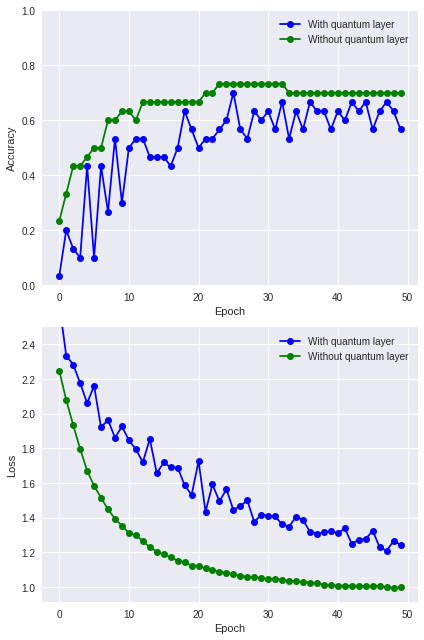

In [48]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h1>Epochs</h1>